# 5-Year US Treasury Constant Maturity Rate (DGS10)-CALIBRAGE

In this study, the time series of the **5-Year US Treasury Constant Maturity Rate (DGS10)** is taken as a significant indicator of the world economy and US economy, from the daily yield data of the Federal Reserve Economic Database (FRED). The major aim is to Conduct an estimation evaluation of three stochastic models:

- **Cox-Ingersoll-Ross (CIR) model** with exact simulation using non-central chi-squared distribution and MLE.

- **Generalized Linear Model (GLM)**: Attempts to model  non-linear relations and heteroskedasticity.

 - **Euler – Maruyama discretization**.







In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Data Preprocessing: 10-Year Treasury Yield  
This section prepares the historical yield data for modeling by addressing data quality and stationarity.  

**Steps**:  
1. **Data Loading**: Import daily 10-Year Treasury yields (FRED DGS10 series) with datetime indexing.  
2. **Cleaning**:  
   - Remove invalid/negative yields.  
   - Fill missing values using time-aware linear interpolation.  
3. **Stationarity Check**: Perform Augmented Dickey-Fuller (ADF) test to validate time series stability.  
4. **Visualization**: Plot the processed yield series to identify residual patterns.  
  

ADF Statistic: -1.2515
p-value: 0.6511


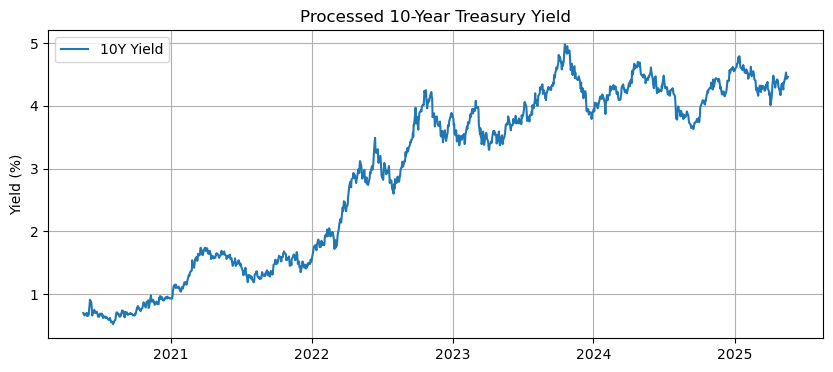

In [2]:
# Loading the dataset
df = pd.read_csv("DGS10.csv", parse_dates=['observation_date'])
df.set_index('observation_date', inplace=True)
df['r_t'] = pd.to_numeric(df['DGS10'], errors='coerce')

df = df[df['r_t'] > 0]  # we take only positive yields 
df = df.asfreq('D').interpolate(method='time')  # Resamping to daily frequency and interpolating missing values based on time
df.dropna(inplace=True)

# Checking for the stationarity
def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
test_stationarity(df['r_t'])

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df['r_t'], label='10Y Yield')
plt.title("Processed 10-Year Treasury Yield")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.legend()
plt.show()


Interpretation:

- #### The time series plot of the cleaned 10-Year Treasury Yield reveals a steep upward trend from mid-2020 to late 2023, rising from below 1% to nearly 5%. This implies a sustained increase in interest rates over the period, perhaps reflecting tightening monetary policy or changing economic fundamentals. After peaking sometime in late 2023, the yield displays more volatile, range-bound dynamics between 4% and 5%, reflecting market uncertainty or policy rate stabilization. The chart is handy for Stochastic Differential Equation (SDE) calibration as it captures both trending and mean-reverting dynamics typical of financial time series.

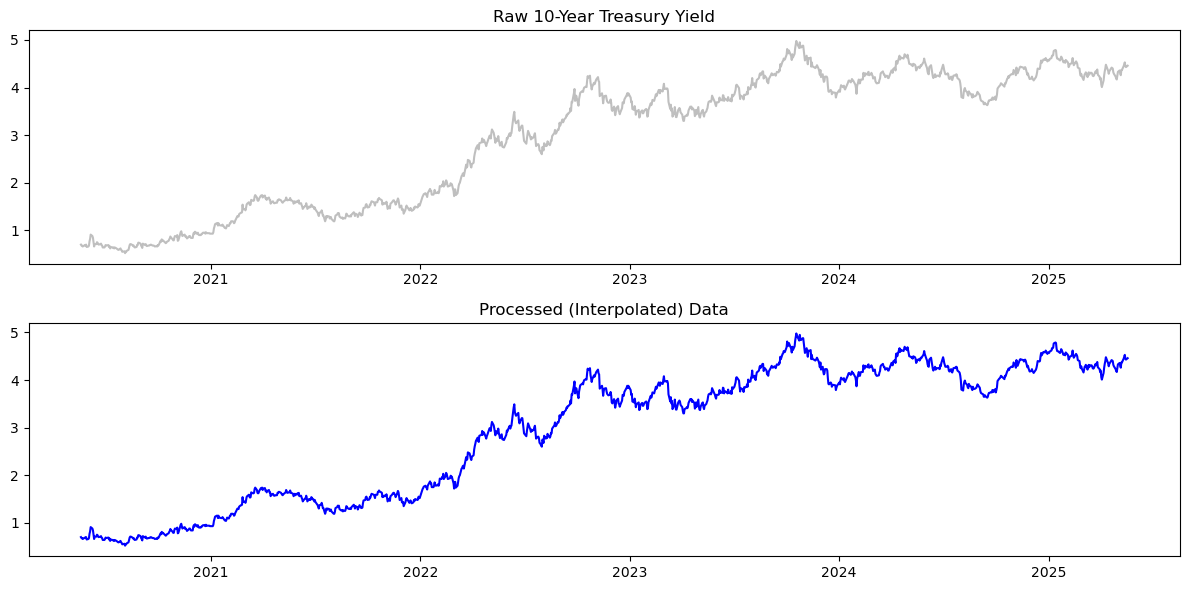

In [3]:
# Plot raw vs. cleaned data
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(df['r_t'], color='gray', alpha=0.5, label='Raw Data')
ax[0].set_title("Raw 10-Year Treasury Yield")
ax[1].plot(df['r_t'], color='blue', label='Processed Data')
ax[1].set_title("Processed (Interpolated) Data")
plt.tight_layout()
plt.show()

## Step 2: Calibration of CIR Maximum Likelihood Estimation (MLE)

Here, we calibrate the **Cox-Ingersoll-Ross (CIR)** interest rate model's parameters:

$ dr_t = (\alpha - \beta r_t) dt + \sigma \sqrt{r_t} dB_t$

We observe daily data and use **maximum likelihood estimation (MLE)** to make estimates for the parameters $ (\alpha), (\beta), and (\sigma)$. The log-likelihood function derives from the condition distribution of r_{t+1} given \r_t  under the CIR model.

Major assumptions:
- Non-negative rates are ensured by the CIR model.
- A rate of Euler-Maruyama is applied to approximate the likelihood.
- An initial estimation and limits for parameters are given to ensure numerical stability during optimization.


In [4]:

def cir_log_likelihood(params, data, dt=1/252):
    alpha, beta, sigma = params
    n = len(data) - 1
    ll = 0
    for i in range(n):
        r_t = data[i]
        r_t1 = data[i+1]
        mu = r_t + (alpha - beta * r_t) * dt
        var = (sigma**2 * r_t * dt)
        if var <= 0 or mu <= 0:  # ignoring invalid parameters
            return -np.inf
        ll += -0.5 * (np.log(2 * np.pi * var) + (r_t1 - mu)**2 / var)
    return ll

# Minimizing negative log-likelihood (which is equivalent to maximizing log-likelihood)
data = df['r_t'].values
initial_guess = [0.1, 0.1, 0.1]  # [alpha, beta, sigma]
bounds = [(0.001, 2), (0.001, 2), (0.001, 2)]
result = minimize(lambda x: -cir_log_likelihood(x, data), initial_guess, bounds=bounds)
alpha_mle, beta_mle, sigma_mle = result.x
print(f"Calibrated CIR Parameters (MLE): α={alpha_mle:.4f}, β={beta_mle:.4f}, σ={sigma_mle:.4f}")


Calibrated CIR Parameters (MLE): α=0.8219, β=0.1030, σ=0.4429


## Log-Likelihood Surface Visualization (α–β Grid Search)

To better understand the sensitivity of the CIR model's likelihood to different parameter values, we perform a **grid search** over a range of $\alpha\ and \beta$, while holding $\sigma$  fixed at its MLE value.

This helps:
- Visualize the **log-likelihood surface**
- Identify potential **local optima**
- Diagnose issues with parameter identifiability or flat regions

The result is a 3D surface plot showing how the log-likelihood changes as a function of \(\alpha\) and \(\beta\).


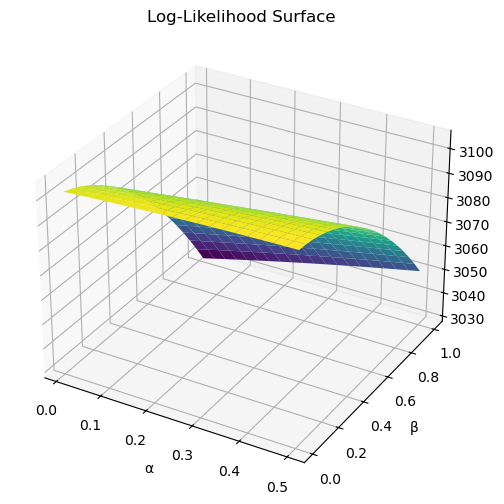

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Grid search for α and β (fixed σ)
alpha_grid = np.linspace(0.01, 0.5, 20)
beta_grid = np.linspace(0.01, 1.0, 20)
log_likelihood = np.zeros((len(alpha_grid), len(beta_grid)))

for i, a in enumerate(alpha_grid):
    for j, b in enumerate(beta_grid):
        log_likelihood[i, j] = cir_log_likelihood([a, b, sigma_mle], data)

#plotting 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(alpha_grid, beta_grid)
ax.plot_surface(X, Y, log_likelihood.T, cmap='viridis')
ax.set_xlabel('α')
ax.set_ylabel('β')
ax.set_title('Log-Likelihood Surface')
plt.show()

## Exact model CIR Simulation based on Non-Central Chi-Squared Distribution

Having already estimated model parameters of the CIR model, we now simulate future interest rate paths according to the **exact solution for the CIR process**. The CIR model has a known transition density, so we can simulate from it via the **non-central chi-squared distribution** to avoid discretization errors in Euler-Maruyama.

We loop:
- Multiple paths through to the same time horizon as historical data
- The path evolves with regard to the closed-form CIR transition dynamics

We then compute the **mean path** and **confidence bands** (5% and 95% quantiles) to draw the simulated rate evolution and compare against observed data.


In [6]:

def exact_cir_sim(r0, alpha, beta, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = r0
    for t in range(1, n_steps + 1):
        c = (sigma**2 * (1 - np.exp(-beta * dt))) / (4 * beta)
        k = (4 * alpha * beta) / sigma**2
        df = 4 * alpha / sigma**2
        nonc = (4 * beta * np.exp(-beta * dt) * paths[t-1]) / (sigma**2 * (1 - np.exp(-beta * dt)))
        paths[t] = c * np.random.noncentral_chisquare(df, nonc, size=n_paths)
    return paths

# Simulation of the parameters
n_paths = 100
n_steps = len(df) - 1
T = n_steps * (1/252)  # taking a annualized horizon
paths = exact_cir_sim(df['r_t'].iloc[0], alpha_mle, beta_mle, sigma_mle, T, n_steps, n_paths)

# Stockin the results
df_sim = pd.DataFrame(paths, index=df.index).T
df['sim_mean'] = df_sim.mean(axis=0)
df['sim_95'] = df_sim.quantile(0.95, axis=0)
df['sim_05'] = df_sim.quantile(0.05, axis=0)


## Step 5: Visualization – Actual vs. CIR Simulated Paths

We now visualize how well the **CIR model simulation** matches the actual observed 10-Year Treasury yields.

In this plot:
- The **black line** shows the actual historical yield.
- The **dashed red line** shows the mean of the simulated CIR paths.
- The **blue shaded region** represents a 90% confidence interval (from the 5th to 95th percentiles of the simulation).

This comparison helps us assess the **realism and predictive capacity** of the calibrated CIR model.


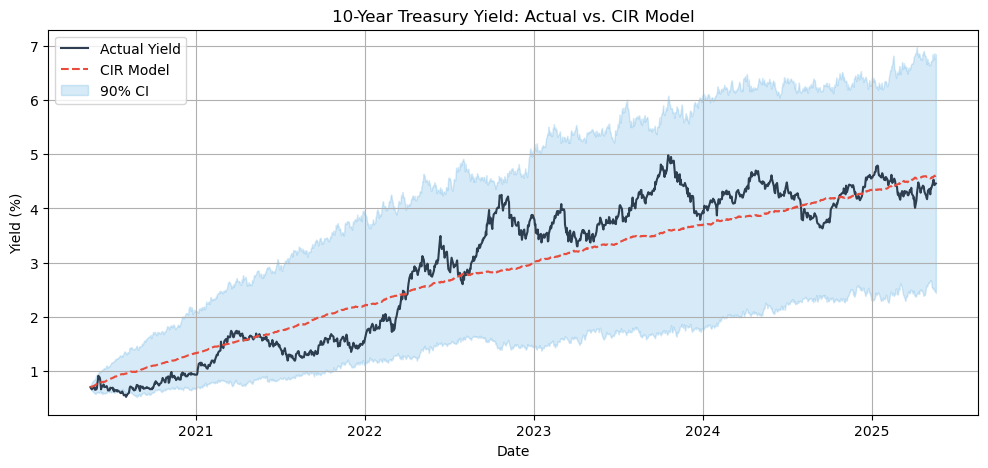

In [7]:
# Comparing between the actual and the simulated CIR
plt.figure(figsize=(12, 5))
plt.plot(df['r_t'], label='Actual Yield', color='#2c3e50', lw=1.5)
plt.plot(df['sim_mean'], label='CIR Model', linestyle='--', color='#e74c3c')
plt.fill_between(df.index, df['sim_05'], df['sim_95'], alpha=0.2, color='#3498db', label='90% CI')
plt.title("10-Year Treasury Yield: Actual vs. CIR Model")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

Interpretation:
- #### This graph superimposes the actual 10-Year Treasury Yield over the fitted Cox-Ingersoll-Ross (CIR) model. While the CIR model (red dashed line) follows the general trend of rise, it does not capture the sudden rise and volatility in the actual data during the period 2022-2023. The 90% confidence interval (shaded area) covers much of the real yield path, which is good model fit, though with large deviations during periods of wild market action. This means that the CIR model possesses a smooth mean-reverting benchmark but is challenged by outliers in yield behavior.










##  Model Diagnostics & Validation

After simulating from the CIR model, it's important to validate how well it captures the behavior of the actual yield data. We perform two key diagnostic tasks:

1. **Fan Chart Visualization**:  
   A visual overlay of the actual yield curve with the simulated mean and 90% confidence bands. This highlights how closely the model tracks reality and where it tends to under- or overshoot.

2. **Residual Analysis**:  
   We compute the residuals (difference between actual and simulated mean yields) and assess their distribution:
   - **Histogram + KDE**: Checks for normality and skewness.
   - **Q-Q Plot**: Compares empirical quantiles to a normal distribution.

These diagnostics help evaluate the CIR model’s **fit quality and statistical assumptions**.


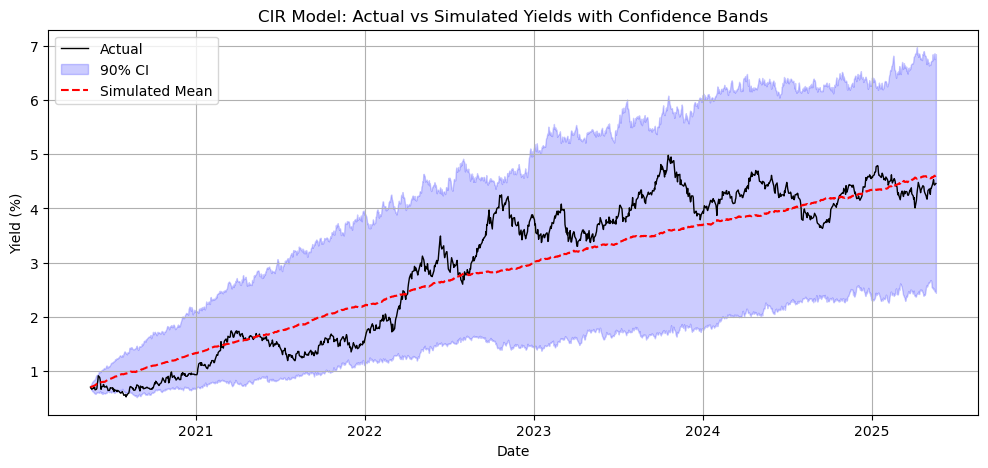

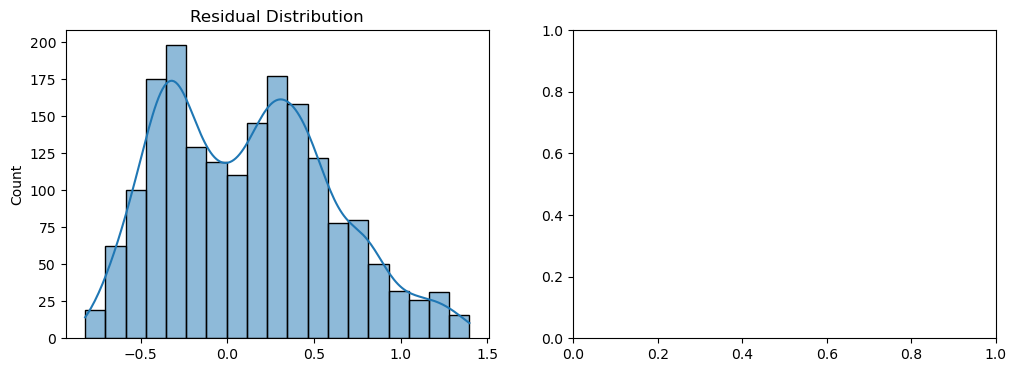

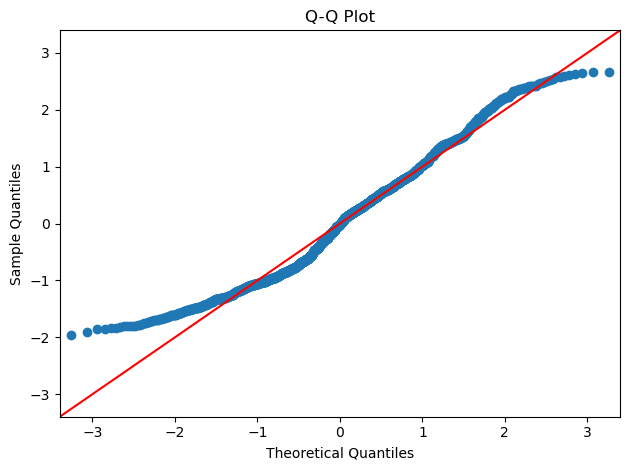

In [8]:
# Plotting fan chart
plt.figure(figsize=(12, 5))
plt.plot(df['r_t'], label='Actual', color='black', lw=1)
plt.fill_between(df.index, df['sim_05'], df['sim_95'], color='blue', alpha=0.2, label='90% CI')
plt.plot(df['sim_mean'], label='Simulated Mean', linestyle='--', color='red')
plt.title("CIR Model: Actual vs Simulated Yields with Confidence Bands")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

import statsmodels.api as sm
# Residual analysis
residuals = df['r_t'] - df['sim_mean']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.subplot(1, 2, 2)
sm.qqplot(residuals.dropna(), line='45', fit=True)
plt.title("Q-Q Plot")
plt.tight_layout()
plt.show()


Interpretation:
- ##### The residual distribution of the CIR model looks moderately skewed with a mode at -0.3 and the right tail being extremely long, suggesting the model to underpredict yields marginally compared to overprediction. Non-normality suggests potential model misspecification or unmodeled market behavior.

## Out-of-Sample Backtesting and Performance Evaluation

To test the **predictive power** of the calibrated CIR model, we perform an **out-of-sample test** with the last 20% of the data as a test set:

### Procedure:
1. **Split the data**:
   - 80% for training (model calibration)
   - 20% for testing (forecast evaluation)

2. **Recalibrate the model** on training data alone using MLE.

3. **Simulate several CIR paths** forward from the latest observed training value using the recalibrated parameters.

4. **Compare predicted values** (average of simulated paths) to past test data:
   - **Calculate Mean Absolute Error (MAE)**
   - **Calculate Root Mean Squared Error (RMSE)**

This backtesting technique gives a good estimate of how much the CIR model will **generalize to unseen future data**.


In [9]:
train_size = int(len(df) * 0.8)
train_data = df['r_t'].iloc[:train_size]
test_data = df['r_t'].iloc[train_size:]

# Recalibrate on training data
result_train = minimize(lambda x: -cir_log_likelihood(x, train_data.values), 
                        initial_guess, bounds=bounds)
alpha_train, beta_train, sigma_train = result_train.x

# Simulating the test paths (n_steps = len(test_data), so output is len(test_data) + 1)
paths_test = exact_cir_sim(
    train_data.iloc[-1], 
    alpha_train, 
    beta_train, 
    sigma_train, 
    T=len(test_data)/252, 
    n_steps=len(test_data),  
    n_paths=100
)

#aligning with test_data index
test_sim = pd.DataFrame(paths_test[1:], index=test_data.index).T  

test_mae = mean_absolute_error(test_data, test_sim.mean(axis=0))
test_rmse = np.sqrt(mean_squared_error(test_data, test_sim.mean(axis=0)))
print(f"Out-of-Sample MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")

Out-of-Sample MAE: 0.5067, RMSE: 0.5664


### Plotting Out-of-Sample Forecast Performance

The next plot compares the CIR model's **out-of-sample forecast** with the actual observed test data:

- **Blue line with markers**: Actual yields in the test set.
- **Dashed line**: Predicted mean path from the CIR model.
- **Green shaded area**: 90% prediction interval (between 5th and 95th percentile of simulated paths).

This comparison provides graphical information about the **accuracy and uncertainty of the forecast** of the CIR model over the held-out horizon.


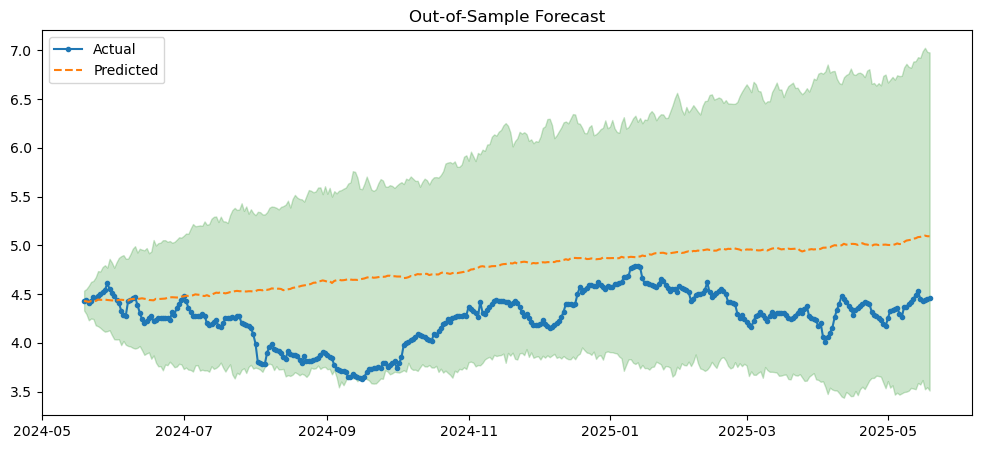

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(test_data, label='Actual', marker='o', markersize=3)
plt.plot(test_sim.mean(axis=0), label='Predicted', linestyle='--')
plt.fill_between(test_data.index, 
                 test_sim.quantile(0.05, axis=0), 
                 test_sim.quantile(0.95, axis=0), 
                 alpha=0.2, color='green')
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.show()

##  Simulating Future Yield Paths (5-Year Projection)

Using the CIR model calibrated on the full dataset, we now generate a **5-year forecast** of future interest rate paths:

### Key points:
- Simulate **252 trading days per year × 5 years = 1260 steps**.
- Start from the **latest observed yield**.
- Use **100 simulated paths** to visualize the uncertainty.

The plot shows:
- **Gray paths**: Individual simulated yield trajectories.
- **Red line**: Median forecast path (central tendency).

This step provides a **probabilistic view** of where yields could go in the future under the CIR dynamics.


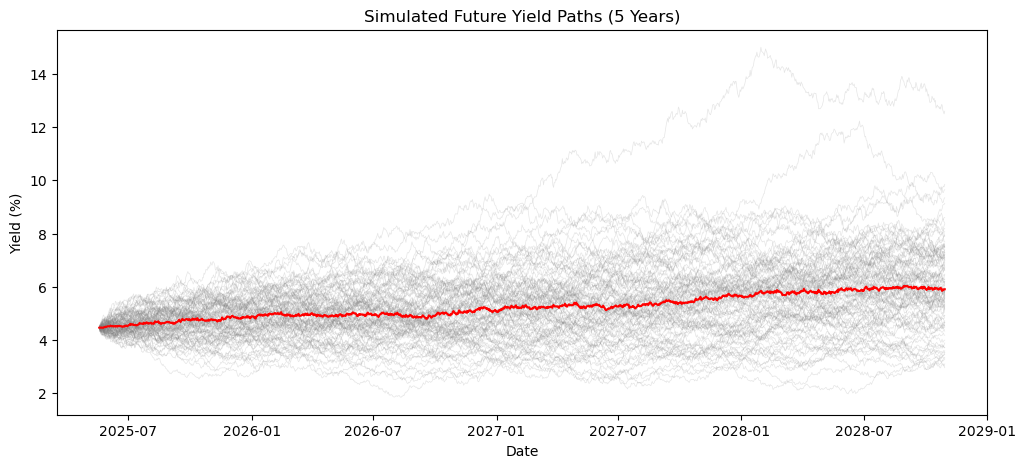

In [11]:
# stp7

future_T = 5  # years
future_steps = int(future_T * 252)
future_paths = exact_cir_sim(
    df['r_t'].iloc[-1], alpha_mle, beta_mle, sigma_mle, 
    T=future_T, n_steps=future_steps, n_paths=100
)
future_dates = pd.date_range(df.index[-1], periods=future_steps+1, freq='D')

plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_paths, lw=0.5, alpha=0.2, color='gray')
plt.plot(future_dates, np.median(future_paths, axis=1), color='red', label='Median')
plt.title("Simulated Future Yield Paths (5 Years)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.show()

# Model Implementation: Generalized Linear Model (GLM)  
The section attempts to fit and analyze an autoregressive GLM on the dynamics of the 10-Year Treasury Yield with lagged terms.  


**Aim**:  Test if a linear autoregressive framework adequately captures yield persistence and volatility patterns observed in the data.   

In [ ]:

import pandas as pd
import numpy as np
import statsmodels.api as sm

df = pd.read_csv("DGS10.csv", parse_dates=['observation_date']) 
df = df.rename(columns={'DGS10': 'yield'})
df.set_index('observation_date', inplace=True)  

df['yield'] = pd.to_numeric(df['yield'], errors='coerce')
df = df.dropna().asfreq('D').interpolate(method='time')

# Creating autoregressive features
lags = 2
for i in range(1, lags+1):
    df[f'yield_lag{i}'] = df['yield'].shift(i)
df = df.dropna()

glm_model = sm.GLM(
    endog=df['yield'],
    exog=sm.add_constant(df[[f'yield_lag{i}' for i in range(1, lags+1)]]),
    family=sm.families.Gaussian()
)
glm_results = glm_model.fit()
df['glm_pred'] = glm_results.predict()

print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  yield   No. Observations:                 1825
Model:                            GLM   Df Residuals:                     1822
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                       0.0021536
Method:                          IRLS   Log-Likelihood:                 3015.2
Date:                Thu, 29 May 2025   Deviance:                       3.9239
Time:                        20:16:28   Pearson chi2:                     3.92
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.003      1.893      0.0

In [ ]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

df = pd.read_csv("DGS10.csv", parse_dates=['observation_date'])
df = df.rename(columns={'DGS10': 'yield'})
df.set_index('observation_date', inplace=True)
df['yield'] = pd.to_numeric(df['yield'], errors='coerce')
df = df.dropna().asfreq('D').interpolate(method='time')

lags = 2
for i in range(1, lags+1):
    df[f'yield_lag{i}'] = df['yield'].shift(i)
df = df.dropna()

# Fit GLM
glm_model = sm.GLM(
    endog=df['yield'],
    exog=sm.add_constant(df[[f'yield_lag{i}' for i in range(1, lags+1)]]),
    family=sm.families.Gaussian()
)
glm_results = glm_model.fit()
df['glm_pred'] = glm_results.predict()


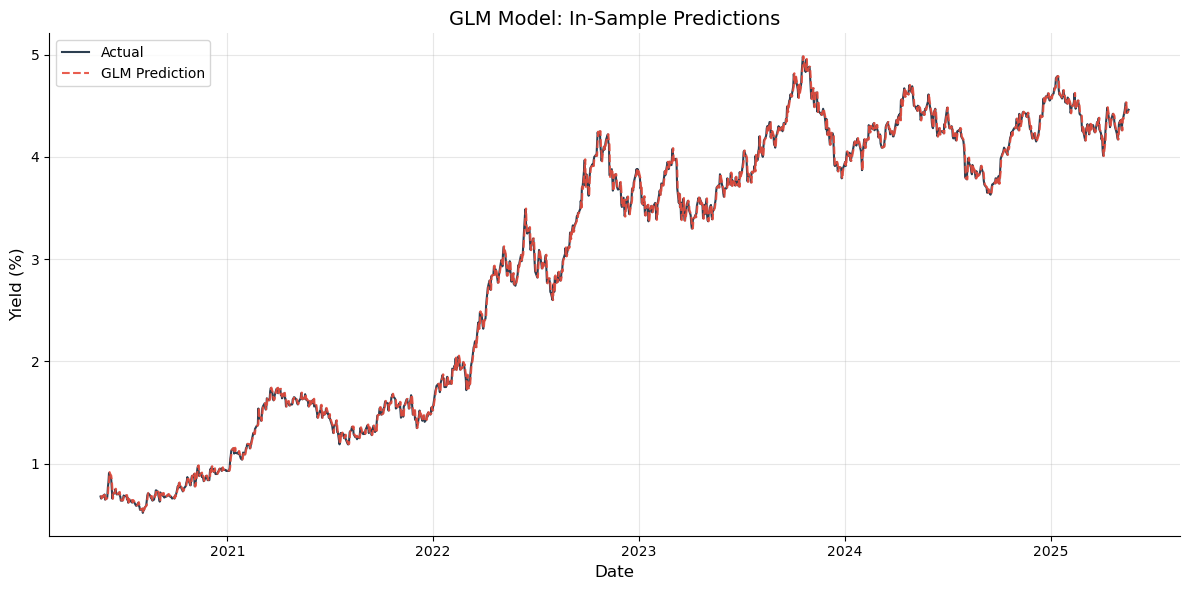

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['yield'], label='Actual', color='#2c3e50', lw=1.5)
plt.plot(df.index, df['glm_pred'], label='GLM Prediction', 
         linestyle='--', color='#e74c3c', alpha=0.9)
plt.title("GLM Model: In-Sample Predictions", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield (%)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


c:\Users\ImeDr\anaconda3_new\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


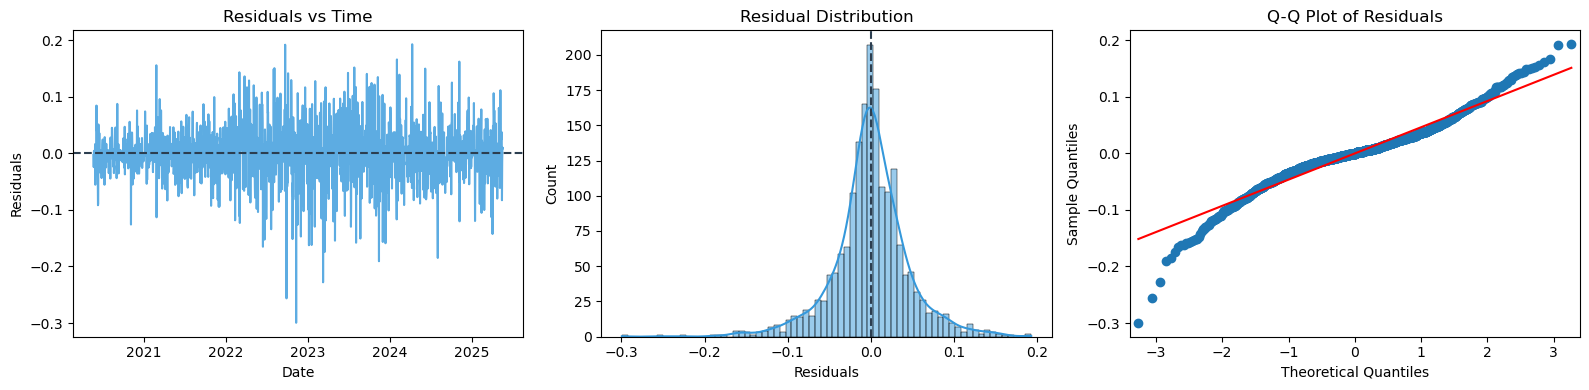

In [15]:
residuals = df['yield'] - df['glm_pred']

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# Residuals over time
ax[0].plot(df.index, residuals, color='#3498db', alpha=0.8)
ax[0].axhline(0, color='#2c3e50', linestyle='--')
ax[0].set_title("Residuals vs Time")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Residuals")

#  histogram
sns.histplot(residuals, kde=True, color='#3498db', ax=ax[1])
ax[1].axvline(0, color='#2c3e50', linestyle='--')
ax[1].set_title("Residual Distribution")
ax[1].set_xlabel("Residuals")

# Q-Q plot
qqplot(residuals, line='s', ax=ax[2], color='#3498db')
ax[2].set_title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()


#### - Residuals vs Time: This graph plots the residuals over the years 2021 to 2025. Residuals should ideally be randomly distributed around zero, meaning that the model's errors are evenly spread out over time. There doesn't appear to be a pattern, which is a good sign.

#### - Residual Distribution: The histogram indicates that residuals are distributed. Most are centered around zero, with a shape that approximates a normal distribution. This implies that the errors of the model are not skewed, which is an indication of something good.

#### - Q-Q Plot of Residuals: This plot plots the residuals against a theoretical normal distribution. The points follow the diagonal red line very closely, which means the residuals are nearly normally distributed.

C:\Users\ImeDr\AppData\Local\Temp\ipykernel_8200\4178680046.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['glm_pred'] = glm_train_results.predict(


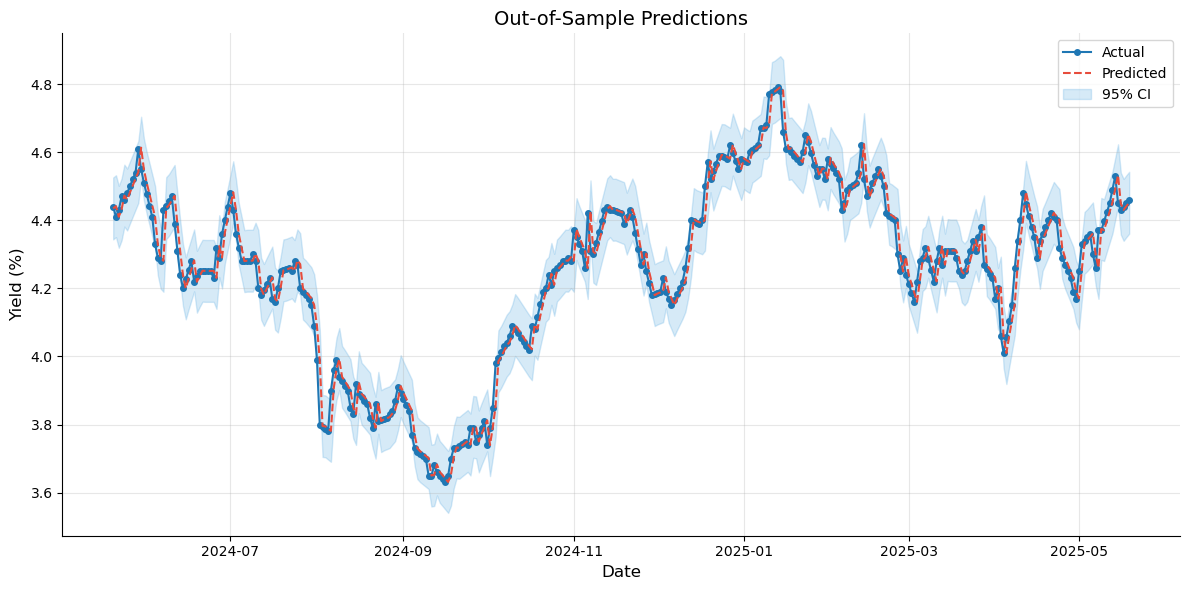

In [16]:

test_size = int(len(df)*0.2)
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

# Retraining on training data
glm_train = sm.GLM(
    endog=train['yield'],
    exog=sm.add_constant(train[[f'yield_lag{i}' for i in range(1, lags+1)]]),
    family=sm.families.Gaussian()
)
glm_train_results = glm_train.fit()
test['glm_pred'] = glm_train_results.predict(
    sm.add_constant(test[[f'yield_lag{i}' for i in range(1, lags+1)]])
)

# plotting
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['yield'], label='Actual', marker='o', markersize=4)
plt.plot(test.index, test['glm_pred'], label='Predicted', 
         linestyle='--', color='#e74c3c')
plt.fill_between(test.index, 
                 test['glm_pred'] - 1.96*np.std(residuals),
                 test['glm_pred'] + 1.96*np.std(residuals),
                 color='#3498db', alpha=0.2, label='95% CI')
plt.title("Out-of-Sample Predictions", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield (%)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

## **Model Calibration using `VasicekCalibrator`**:
- Now we're trying to develop a specialized `VasicekCalibrator` class to estimate CIR model parameters (mean-reversion level `alpha`, speed `beta`, volatility `sigma`) using Maximum Likelihood Estimation (MLE).




ADF Statistic: -1.2515
p-value: 0.6511
Series is non-stationary

VASICEK MODEL CALIBRATION

Calibrated Parameters:
α (alpha): 0.008158
β (beta):  0.100005
σ (sigma): 0.044290

Derived Statistics:
Long-term mean: 0.0816 (8.16%)
Half-life (years): 6.93
Mean reversion speed: 0.1000

Model Fit Statistics:
Residuals_Mean: 0.001091
Residuals_Std: 0.999998
Ljung_Box_Stat: 18.002561
Jarque_Bera_Stat: 491.398406
Log-Likelihood: 11515.078705

RESIDUAL ANALYSIS


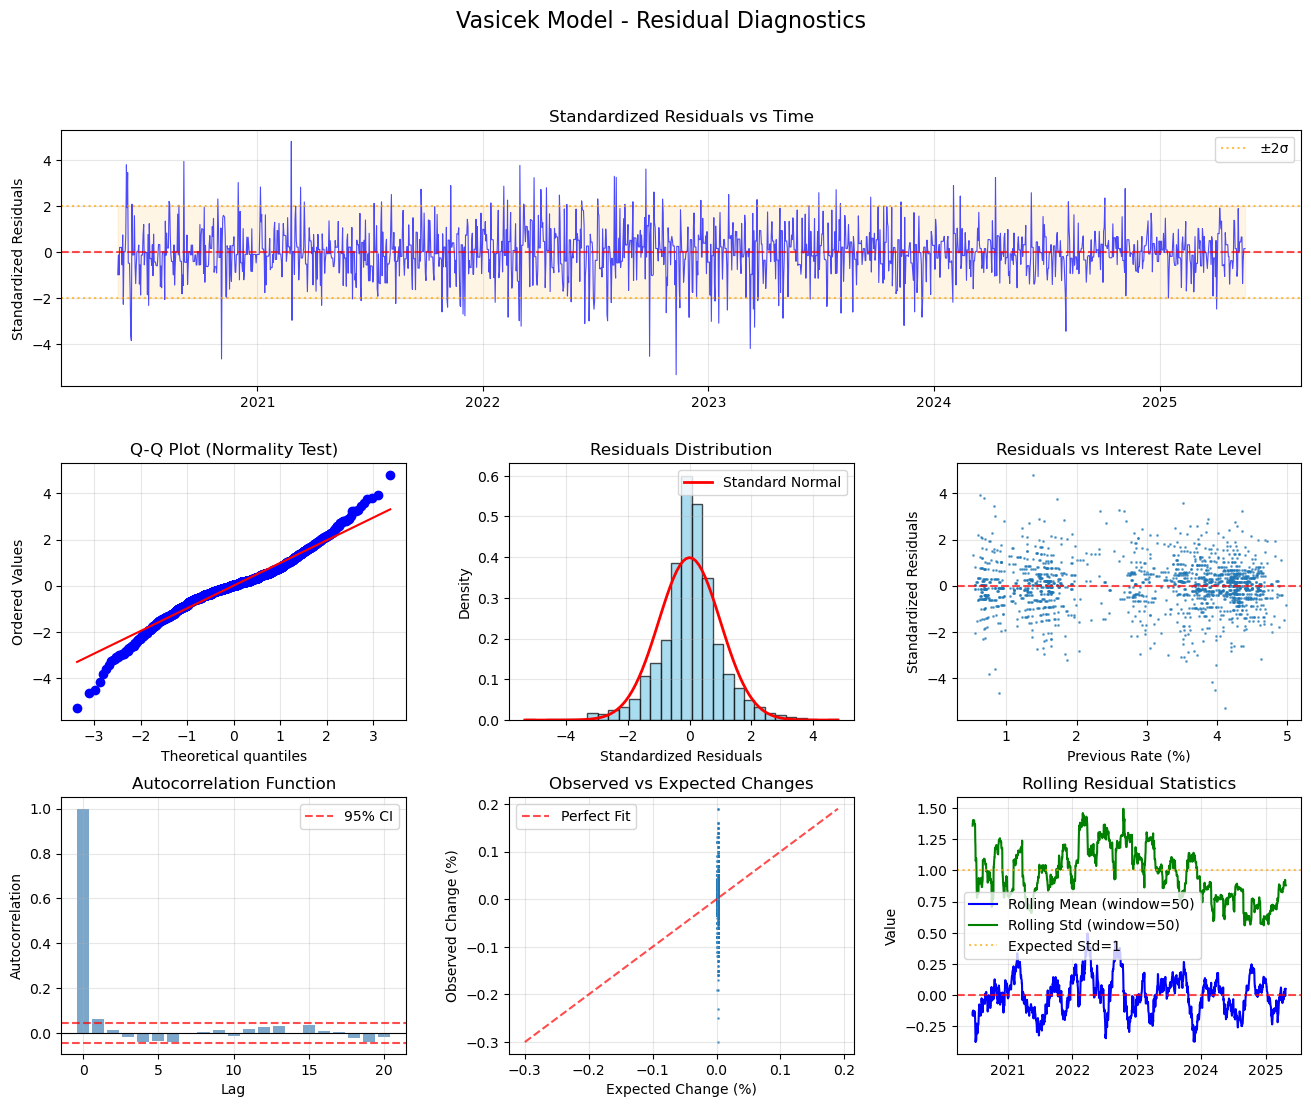


RESIDUAL DIAGNOSTICS SUMMARY
Residuals Mean: 0.001091 (should be ~0)
Residuals Std: 0.999998 (should be ~1)
Residuals Skewness: -0.1482 (should be ~0)
Residuals Kurtosis: 2.5240 (should be ~0)

Outliers (|residual| > 2σ): 111 (6.1%)
Outliers (|residual| > 3σ): 24 (1.3%)
Expected: ~5% for 2σ, ~0.3% for 3σ

Normality Tests:
Jarque-Bera: statistic=491.3984, p-value=0.000000
Shapiro-Wilk: statistic=0.9645, p-value=0.000000
p-value > 0.05 suggests residuals are normally distributed

Autocorrelation at lag 1: 0.0640
Should be close to 0 for white noise residuals

GENERATING SIMULATIONS
Future dates length: 504
Simulation data shape: (1000, 505)
Percentiles shape: (5, 505)


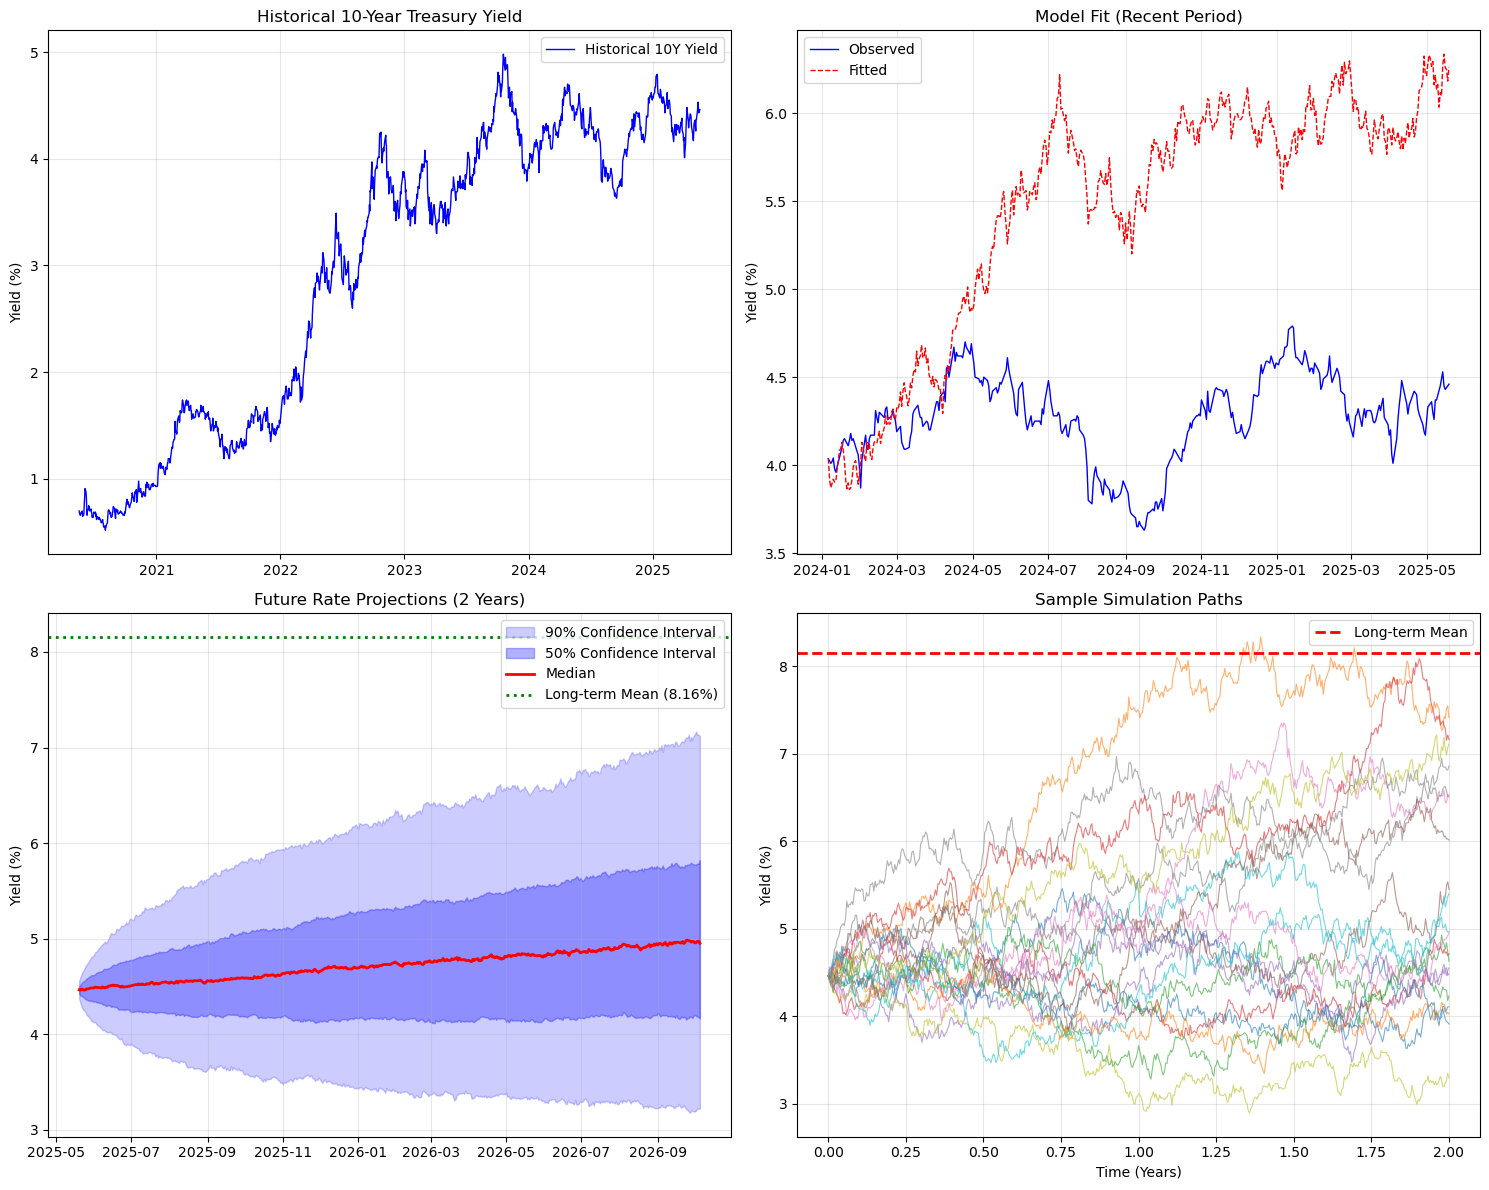


Simulation Summary (at T=2 years):
Mean rate: 5.03%
Std deviation: 1.17%
5th percentile: 3.22%
95th percentile: 7.12%
Probability of rate > 5%: 49.0%
Probability of rate < 2%: 0.1%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("DGS10.csv", parse_dates=['observation_date'])
df.set_index('observation_date', inplace=True)
df['r_t'] = pd.to_numeric(df['DGS10'], errors='coerce')
df = df[df['r_t'] > 0]  
df = df.asfreq('D').interpolate(method='time')  
df.dropna(inplace=True)
df['r_t'] = df['r_t'] / 100

def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")

test_stationarity(df['r_t'])

class VasicekCalibrator:
    def __init__(self, data, dt=1/252):
        self.data = data.values
        self.dt = dt
        self.n = len(self.data)
        
    def log_likelihood(self, params):
        alpha, beta, sigma = params
        
        if beta <= 0 or sigma <= 0:
            return np.inf
            
        # we calculate the increments
        dr = np.diff(self.data)
        r_prev = self.data[:-1]
        
        # rxpected drift and variance for each step
        drift = (alpha - beta * r_prev) * self.dt
        variance = sigma**2 * r_prev * self.dt
        
        # we avoid zero or negative variance
        variance = np.maximum(variance, 1e-10)
        
        # calculating log-likelihood 
        ll = -0.5 * np.sum(np.log(2 * np.pi * variance)) - 0.5 * np.sum((dr - drift)**2 / variance)
        
        return -ll  
    
    def calibrate(self, initial_guess=None):

        if initial_guess is None:
            # Initial guess based on data characteristics
            mean_rate = np.mean(self.data)
            vol_rate = np.std(np.diff(self.data)) / np.sqrt(self.dt)
            initial_guess = [mean_rate * 0.1, 0.1, vol_rate]
        
        bounds = [(-np.inf, np.inf), (1e-6, 10), (1e-6, 1)]
        
        # monimizing the negative log-likelihood
        result = minimize(
            self.log_likelihood,
            initial_guess,
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000}
        )
        
        if result.success:
            self.alpha, self.beta, self.sigma = result.x
            self.log_likelihood_value = -result.fun
            return result.x
        else:
            raise ValueError("Optimization failed to converge")
    
    def euler_maruyama_simulation(self, r0, T, n_steps, n_paths=1):
        dt_sim = T / n_steps
        times = np.linspace(0, T, n_steps + 1)
        
        paths = np.zeros((n_paths, n_steps + 1))
        paths[:, 0] = r0
        
        # Generating random numbers
        dW = np.random.normal(0, np.sqrt(dt_sim), (n_paths, n_steps))
        
        # Euler-Maruyama steps
        for i in range(n_steps):
            r_current = paths[:, i]
            r_current = np.maximum(r_current, 1e-10)
            
            drift = (self.alpha - self.beta * r_current) * dt_sim
            diffusion = self.sigma * np.sqrt(r_current) * dW[:, i]
            
            paths[:, i + 1] = r_current + drift + diffusion
            paths[:, i + 1] = np.maximum(paths[:, i + 1], 0)
        
        return times, paths
    
    def calculate_residuals(self):

        dr_observed = np.diff(self.data)
        r_prev = self.data[:-1]
        
        drift_expected = (self.alpha - self.beta * r_prev) * self.dt
        variance_expected = self.sigma**2 * r_prev * self.dt
        
        variance_expected = np.maximum(variance_expected, 1e-10)
        
        # Raw residuals
        residuals_raw = dr_observed - drift_expected
        
        # Standardized residuals
        residuals_std = residuals_raw / np.sqrt(variance_expected)
        
        return {
            'raw_residuals': residuals_raw,
            'standardized_residuals': residuals_std,
            'drift_expected': drift_expected,
            'variance_expected': variance_expected,
            'dr_observed': dr_observed,
            'r_prev': r_prev
        }
    
    def calculate_fit_statistics(self):

        residuals_data = self.calculate_residuals()
        residuals_std = residuals_data['standardized_residuals']
        
        residuals_mean = np.mean(residuals_std)
        residuals_std_dev = np.std(residuals_std)
        
        #we use Ljung-Box test for autocorrelation
        def ljung_box_statistic(residuals, lags=10):
            n = len(residuals)
            acf_values = []
            for lag in range(1, min(lags + 1, n)):
                if lag < n:
                    corr = np.corrcoef(residuals[:-lag], residuals[lag:])[0, 1]
                    if not np.isnan(corr):
                        acf_values.append(corr**2 / (n - lag))
            return n * (n + 2) * np.sum(acf_values) if acf_values else 0
        
        lb_stat = ljung_box_statistic(residuals_std)
        
        # Jarque-Bera test statistic for normality
        def jarque_bera_statistic(residuals):
            n = len(residuals)
            skewness = np.mean(((residuals - np.mean(residuals)) / np.std(residuals))**3)
            kurtosis = np.mean(((residuals - np.mean(residuals)) / np.std(residuals))**4) - 3
            return n/6 * (skewness**2 + (kurtosis**2)/4)
        
        jb_stat = jarque_bera_statistic(residuals_std)
        
        return {
            'Residuals_Mean': residuals_mean,
            'Residuals_Std': residuals_std_dev,
            'Ljung_Box_Stat': lb_stat,
            'Jarque_Bera_Stat': jb_stat,
            'Log-Likelihood': self.log_likelihood_value
        }
    
    def plot_residuals_diagnostics(self, figsize=(16, 12)):
        """
        Create comprehensive residuals diagnostic plots
        """
        residuals_data = self.calculate_residuals()
        residuals_std = residuals_data['standardized_residuals']
        residuals_raw = residuals_data['raw_residuals']
        r_prev = residuals_data['r_prev']
        dr_observed = residuals_data['dr_observed']
        drift_expected = residuals_data['drift_expected']
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Standardized Residuals vs Time
        ax1 = fig.add_subplot(gs[0, :])
        dates_residuals = self.data_dates[1:] if hasattr(self, 'data_dates') else range(len(residuals_std))
        ax1.plot(dates_residuals, residuals_std, 'b-', alpha=0.7, linewidth=0.8)
        ax1.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        ax1.axhline(y=2, color='orange', linestyle=':', alpha=0.7, label='±2σ')
        ax1.axhline(y=-2, color='orange', linestyle=':', alpha=0.7)
        ax1.fill_between(dates_residuals, -2, 2, alpha=0.1, color='orange')
        ax1.set_title('Standardized Residuals vs Time')
        ax1.set_ylabel('Standardized Residuals')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # 2. Q-Q Plot for Normality
        ax2 = fig.add_subplot(gs[1, 0])
        from scipy import stats
        stats.probplot(residuals_std, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot (Normality Test)')
        ax2.grid(True, alpha=0.3)
        
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.hist(residuals_std, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        # Overlay normal distribution
        x_norm = np.linspace(residuals_std.min(), residuals_std.max(), 100)
        ax3.plot(x_norm, stats.norm.pdf(x_norm, 0, 1), 'r-', linewidth=2, label='Standard Normal')
        ax3.set_title('Residuals Distribution')
        ax3.set_xlabel('Standardized Residuals')
        ax3.set_ylabel('Density')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        ax4 = fig.add_subplot(gs[1, 2])
        ax4.scatter(r_prev * 100, residuals_std, alpha=0.6, s=1)
        ax4.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        ax4.set_title('Residuals vs Interest Rate Level')
        ax4.set_xlabel('Previous Rate (%)')
        ax4.set_ylabel('Standardized Residuals')
        ax4.grid(True, alpha=0.3)
        
        # visualizong rhe autocorrelation Function (ACF)
        ax5 = fig.add_subplot(gs[2, 0])
        def autocorr_function(x, max_lag=20):
            n = len(x)
            x = x - np.mean(x)
            autocorrs = np.correlate(x, x, mode='full')
            autocorrs = autocorrs[n-1:n-1+max_lag+1]
            autocorrs = autocorrs / autocorrs[0]
            return autocorrs
        
        lags = range(21)
        acf_values = autocorr_function(residuals_std)
        ax5.bar(lags, acf_values, alpha=0.7, color='steelblue')
        ax5.axhline(y=0, color='black', linewidth=0.8)
        ax5.axhline(y=1.96/np.sqrt(len(residuals_std)), color='red', linestyle='--', alpha=0.7, label='95% CI')
        ax5.axhline(y=-1.96/np.sqrt(len(residuals_std)), color='red', linestyle='--', alpha=0.7)
        ax5.set_title('Autocorrelation Function')
        ax5.set_xlabel('Lag')
        ax5.set_ylabel('Autocorrelation')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        ax6 = fig.add_subplot(gs[2, 1])
        ax6.scatter(drift_expected * 100, dr_observed * 100, alpha=0.6, s=1)
        min_val = min(drift_expected.min(), dr_observed.min()) * 100
        max_val = max(drift_expected.max(), dr_observed.max()) * 100
        ax6.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Fit')
        ax6.set_title('Observed vs Expected Changes')
        ax6.set_xlabel('Expected Change (%)')
        ax6.set_ylabel('Observed Change (%)')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # 7. Rolling Statistics
        ax7 = fig.add_subplot(gs[2, 2])
        window = min(50, len(residuals_std) // 10)
        rolling_mean = pd.Series(residuals_std).rolling(window=window, center=True).mean()
        rolling_std = pd.Series(residuals_std).rolling(window=window, center=True).std()
        
        dates_rolling = dates_residuals if hasattr(dates_residuals, '__len__') else range(len(rolling_mean))
        ax7.plot(dates_rolling, rolling_mean, 'b-', label=f'Rolling Mean (window={window})', linewidth=1.5)
        ax7.plot(dates_rolling, rolling_std, 'g-', label=f'Rolling Std (window={window})', linewidth=1.5)
        ax7.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        ax7.axhline(y=1, color='orange', linestyle=':', alpha=0.7, label='Expected Std=1')
        ax7.set_title('Rolling Residual Statistics')
        ax7.set_ylabel('Value')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        
        plt.suptitle('Vasicek Model - Residual Diagnostics', fontsize=16, y=0.98)
        plt.show()
        
        # Print diagnostic summary
        print("\n" + "="*60)
        print("RESIDUAL DIAGNOSTICS SUMMARY")
        print("="*60)
        
        # ptinting basic statistics
        print(f"Residuals Mean: {np.mean(residuals_std):.6f} (should be ~0)")
        print(f"Residuals Std: {np.std(residuals_std):.6f} (should be ~1)")
        print(f"Residuals Skewness: {stats.skew(residuals_std):.4f} (should be ~0)")
        print(f"Residuals Kurtosis: {stats.kurtosis(residuals_std):.4f} (should be ~0)")
        
        # counting outliers
        outliers_2sigma = np.sum(np.abs(residuals_std) > 2)
        outliers_3sigma = np.sum(np.abs(residuals_std) > 3)
        print(f"\nOutliers (|residual| > 2σ): {outliers_2sigma} ({outliers_2sigma/len(residuals_std)*100:.1f}%)")
        print(f"Outliers (|residual| > 3σ): {outliers_3sigma} ({outliers_3sigma/len(residuals_std)*100:.1f}%)")
        print("Expected: ~5% for 2σ, ~0.3% for 3σ")
        
        #  tests of normality
        jb_stat, jb_pvalue = stats.jarque_bera(residuals_std)
        sw_stat, sw_pvalue = stats.shapiro(residuals_std[:5000] if len(residuals_std) > 5000 else residuals_std)
        
        print(f"\nNormality Tests:")
        print(f"Jarque-Bera: statistic={jb_stat:.4f}, p-value={jb_pvalue:.6f}")
        print(f"Shapiro-Wilk: statistic={sw_stat:.4f}, p-value={sw_pvalue:.6f}")
        print("p-value > 0.05 suggests residuals are normally distributed")
        
        # autocorrelation test
        acf_first_lag = np.corrcoef(residuals_std[:-1], residuals_std[1:])[0, 1]
        print(f"\nAutocorrelation at lag 1: {acf_first_lag:.4f}")
        print("Should be close to 0 for white noise residuals")
        
        return fig

# now we calibrate the model
print("\n" + "="*50)
print("VASICEK MODEL CALIBRATION")
print("="*50)

calibrator = VasicekCalibrator(df['r_t'], dt=1/252)
# we store dates for residual analysis
calibrator.data_dates = df.index
params = calibrator.calibrate()

alpha, beta, sigma = params
print(f"\nCalibrated Parameters:")
print(f"α (alpha): {alpha:.6f}")
print(f"β (beta):  {beta:.6f}")
print(f"σ (sigma): {sigma:.6f}")

# wa calculate long-term mean and mean reversion speed
long_term_mean = alpha / beta
half_life = np.log(2) / beta
print(f"\nDerived Statistics:")
print(f"Long-term mean: {long_term_mean:.4f} ({long_term_mean*100:.2f}%)")
print(f"Half-life (years): {half_life:.2f}")
print(f"Mean reversion speed: {beta:.4f}")

# calculate fit statistics
fit_stats = calibrator.calculate_fit_statistics()
print(f"\nModel Fit Statistics:")
for stat, value in fit_stats.items():
    print(f"{stat}: {value:.6f}")

# RESIDUAL ANALYSIS
print("\n" + "="*50)
print("RESIDUAL ANALYSIS")
print("="*50)

# plotting comprehensive residual diagnostics
residual_fig = calibrator.plot_residuals_diagnostics()

# generating simulations for visualization
print("\n" + "="*50)
print("GENERATING SIMULATIONS")
print("="*50)

r0 = df['r_t'].iloc[-1]  # Start from last observed rate
T = 2  # 2 years forward
n_steps = int(T * 252)  # Daily steps
n_paths = 1000

times, paths = calibrator.euler_maruyama_simulation(r0, T, n_steps, n_paths)

# create comprehensive plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Historical data
ax1.plot(df.index, df['r_t'] * 100, 'b-', linewidth=1, label='Historical 10Y Yield')
ax1.set_title('Historical 10-Year Treasury Yield')
ax1.set_ylabel('Yield (%)')
ax1.grid(True, alpha=0.3)
ax1.legend()

sample_end = min(500, len(df))  # Show last 500 days or all data
historical_sample = df['r_t'].iloc[-sample_end:] * 100
dates_sample = df.index[-sample_end:]

# Generate one fitted path for comparison
_, fitted_path = calibrator.euler_maruyama_simulation(
    historical_sample.iloc[0]/100, sample_end/252, sample_end-1, n_paths=1
)

ax2.plot(dates_sample, historical_sample, 'b-', linewidth=1, label='Observed')
ax2.plot(dates_sample, fitted_path[0, :] * 100, 'r--', linewidth=1, label='Fitted')
ax2.set_title('Model Fit (Recent Period)')
ax2.set_ylabel('Yield (%)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Creating future dates starting from the day after the last observation
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='D')
percentiles = np.percentile(paths * 100, [5, 25, 50, 75, 95], axis=0)
print(f"Future dates length: {len(future_dates)}")
print(f"Simulation data shape: {paths.shape}")
print(f"Percentiles shape: {percentiles.shape}")

# we use only the simulation data 
percentiles_sim = percentiles[:, 1:]  
future_dates = future_dates[:percentiles_sim.shape[1]]  

ax3.fill_between(future_dates, percentiles_sim[0, :], percentiles_sim[4, :], 
                alpha=0.2, color='blue', label='90% Confidence Interval')
ax3.fill_between(future_dates, percentiles_sim[1, :], percentiles_sim[3, :], 
                alpha=0.3, color='blue', label='50% Confidence Interval')
ax3.plot(future_dates, percentiles_sim[2, :], 'r-', linewidth=2, label='Median')
ax3.axhline(y=long_term_mean*100, color='g', linestyle=':', linewidth=2, 
           label=f'Long-term Mean ({long_term_mean*100:.2f}%)')
ax3.set_title('Future Rate Projections (2 Years)')
ax3.set_ylabel('Yield (%)')
ax3.grid(True, alpha=0.3)
ax3.legend()

sample_paths = paths[:20, :] * 100  
for i in range(20):
    ax4.plot(times, sample_paths[i, :], alpha=0.6, linewidth=0.8)
ax4.axhline(y=long_term_mean*100, color='r', linestyle='--', linewidth=2, 
           label=f'Long-term Mean')
ax4.set_title('Sample Simulation Paths')
ax4.set_xlabel('Time (Years)')
ax4.set_ylabel('Yield (%)')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

# Summary statistics for simulations
print(f"\nSimulation Summary (at T=2 years):")
final_rates = paths[:, -1] * 100
print(f"Mean rate: {np.mean(final_rates):.2f}%")
print(f"Std deviation: {np.std(final_rates):.2f}%")
print(f"5th percentile: {np.percentile(final_rates, 5):.2f}%")
print(f"95th percentile: {np.percentile(final_rates, 95):.2f}%")
print(f"Probability of rate > 5%: {np.mean(final_rates > 5)*100:.1f}%")
print(f"Probability of rate < 2%: {np.mean(final_rates < 2)*100:.1f}%")

## CONCLUSION :COMPARISON BETWEEN THE MODELS FOR OUR STUDY CASE

- Out of the residual diagnostics under Vasicek, GLM, and CIR models, we have the following calibration performance comparison between them:

- The Vasicek model displays a reasonably good fit, with standardized residuals close to zero and having a standard deviation close to one. However, residual diagnostics (e.g., Jarque-Bera test and Q-Q plot) reveal non-normality and mild autocorrelation, which suggests some misspecification. Of notable interest, the variance of the residuals seems time-varying, and there is mild clustering, which indicates non-constant volatility that Vasicek does not capture.

- The GLM model, although having residuals with almost zero mean and unit variance, has more significant deviations from normality. The histogram illustrates heavier tails and asymmetry, and the null hypothesis is rejected by normality tests. The Q-Q plot also agrees with these problems, and there are systematic deviations from the line of reference. Autocorrelation is minimal, which is a good point, but the occurrence of outliers larger than ±3σ more often than would be expected indicates possible misfit of the model for extreme cases.

- The CIR model, on the other hand, has a bad residual distribution. The residual histogram is clearly multi-modal and skew, indicating a strongly non-normal distribution. This would mean that the CIR model cannot accurately capture the underlying dynamics of the observed interest rate data, likely due to its strictly positive domain and square-root diffusion nature that do not accommodate well near-zero or negative rate movements in the data history.

- In conclusion, while none of the models captures the residual shape with perfection, the Vasicek model has the best overall calibration of the three. It finds a good balance between empirical fit and simplicity, although its limitations under heteroskedasticity and distributional assumptions remain. The GLM model fits better under serial independence but fails to produce Gaussian residuals. The CIR model also has the poorest fit, which is an indication that it's not quite suitable for this dataset without further fine-tuning or modification.".
